# Cell 1: Setup & Load Data

In [2]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Imports
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from collections import Counter

# ML imports
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer

# Set style
plt.style.use('seaborn-v0_8-whitegrid')

# Define paths
BASE_PATH = '/content/drive/MyDrive/same_words_different_worlds'

PATHS = {
    'raw': os.path.join(BASE_PATH, 'data/raw'),
    'processed': os.path.join(BASE_PATH, 'data/processed'),
    'outputs': os.path.join(BASE_PATH, 'data/outputs'),
    'models': os.path.join(BASE_PATH, 'models'),
    'figures': os.path.join(BASE_PATH, 'figures'),
}

# Load embeddings
df = pd.read_pickle(os.path.join(PATHS['processed'], '02_tweets_with_embeddings.pkl'))

print(f"✓ Loaded {len(df):,} tweets with embeddings")
print(f"  Democrats: {len(df[df['party']=='D']):,}")
print(f"  Republicans: {len(df[df['party']=='R']):,}")

Mounted at /content/drive
✓ Loaded 3,201 tweets with embeddings
  Democrats: 2,022
  Republicans: 1,179


# Cell 2: Train Classifier & Define Partisan Axis

In [3]:
# Train classifier to define the D ↔ R partisan axis
from sklearn.linear_model import LogisticRegression

# Prepare data
X = np.stack(df['embedding'].values)
y = df['party'].values

# Train classifier
clf = LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42)
clf.fit(X, y)

# The coefficient vector defines the "partisan axis"
# Positive direction = Republican, Negative direction = Democrat
partisan_axis = clf.coef_[0]
partisan_axis = partisan_axis / np.linalg.norm(partisan_axis)  # Normalize

print("✓ Partisan axis defined")
print(f"  Classifier accuracy: {clf.score(X, y):.1%}")
print(f"  Axis shape: {partisan_axis.shape}")

# Function to project tweets onto partisan axis
def project_onto_axis(embeddings, axis):
    """Project embeddings onto the partisan axis. Returns scalar scores."""
    return np.dot(embeddings, axis)

# Test: project all tweets
all_projections = project_onto_axis(X, partisan_axis)
df['partisan_score'] = all_projections

print(f"\nPartisan score distribution:")
print(f"  Democrat mean:    {df[df['party']=='D']['partisan_score'].mean():.4f}")
print(f"  Republican mean:  {df[df['party']=='R']['partisan_score'].mean():.4f}")
print(f"  (Negative = D-leaning, Positive = R-leaning)")

✓ Partisan axis defined
  Classifier accuracy: 78.1%
  Axis shape: (768,)

Partisan score distribution:
  Democrat mean:    -0.0666
  Republican mean:  0.0301
  (Negative = D-leaning, Positive = R-leaning)


# Cell 3: SemAxis Projection Function

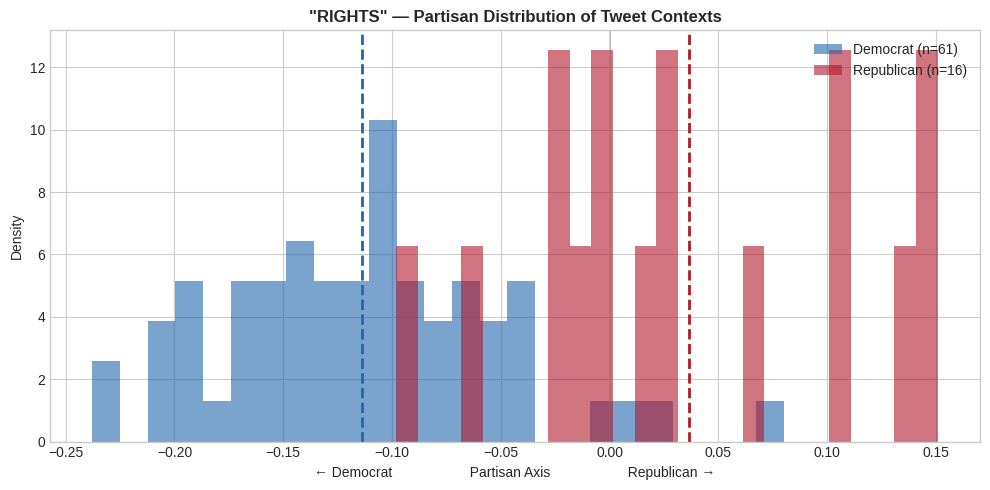

✓ Figure saved to: /content/drive/MyDrive/same_words_different_worlds/figures/10_semaxis_rights.png

Statistics for 'rights':
  D mean: -0.1137, R mean: 0.0366
  Separation: 0.1503


In [4]:
def plot_semaxis_distribution(word, df, partisan_axis, ax=None, save_path=None):
    """
    Plot the distribution of tweets containing a word on the partisan axis,
    separated by party.
    """
    # Find tweets containing the word
    pattern = r'\b' + re.escape(word) + r'\b'
    mask = df['clean_text'].str.contains(pattern, case=False, regex=True, na=False)
    subset = df[mask].copy()

    if len(subset) < 20:
        return None

    # Get projections
    d_tweets = subset[subset['party'] == 'D']
    r_tweets = subset[subset['party'] == 'R']

    d_scores = d_tweets['partisan_score'].values
    r_scores = r_tweets['partisan_score'].values

    if ax is None:
        fig, ax = plt.subplots(figsize=(10, 5))

    # Plot histograms
    ax.hist(d_scores, bins=25, alpha=0.6, color='#2166AC', label=f'Democrat (n={len(d_tweets)})', density=True)
    ax.hist(r_scores, bins=25, alpha=0.6, color='#B2182B', label=f'Republican (n={len(r_tweets)})', density=True)

    # Add mean lines
    ax.axvline(d_scores.mean(), color='#2166AC', linestyle='--', linewidth=2)
    ax.axvline(r_scores.mean(), color='#B2182B', linestyle='--', linewidth=2)

    # Formatting
    ax.set_xlabel('← Democrat                    Partisan Axis                    Republican →', fontsize=10)
    ax.set_ylabel('Density', fontsize=10)
    ax.set_title(f'"{word.upper()}" — Partisan Distribution of Tweet Contexts', fontsize=12, fontweight='bold')
    ax.legend(loc='upper right')
    ax.axvline(0, color='gray', linestyle='-', alpha=0.3)

    # Calculate overlap statistics
    mean_diff = r_scores.mean() - d_scores.mean()

    return {
        'word': word,
        'd_mean': d_scores.mean(),
        'r_mean': r_scores.mean(),
        'mean_diff': mean_diff,
        'd_count': len(d_tweets),
        'r_count': len(r_tweets)
    }

# Test with "rights"
fig, ax = plt.subplots(figsize=(10, 5))
result = plot_semaxis_distribution('rights', df, partisan_axis, ax)
plt.tight_layout()

# Save figure
save_path = os.path.join(PATHS['figures'], '10_semaxis_rights.png')
plt.savefig(save_path, dpi=300, bbox_inches='tight')
plt.show()

print(f"✓ Figure saved to: {save_path}")

if result:
    print(f"\nStatistics for 'rights':")
    print(f"  D mean: {result['d_mean']:.4f}, R mean: {result['r_mean']:.4f}")
    print(f"  Separation: {result['mean_diff']:.4f}")

Excellent visualization! The separation is clear—Democrat tweets about "rights" cluster on the left (negative), Republican tweets cluster on the right (positive). The distributions barely overlap, showing genuinely different contexts.

# Cell 4: SemAxis Grid for Multiple Words

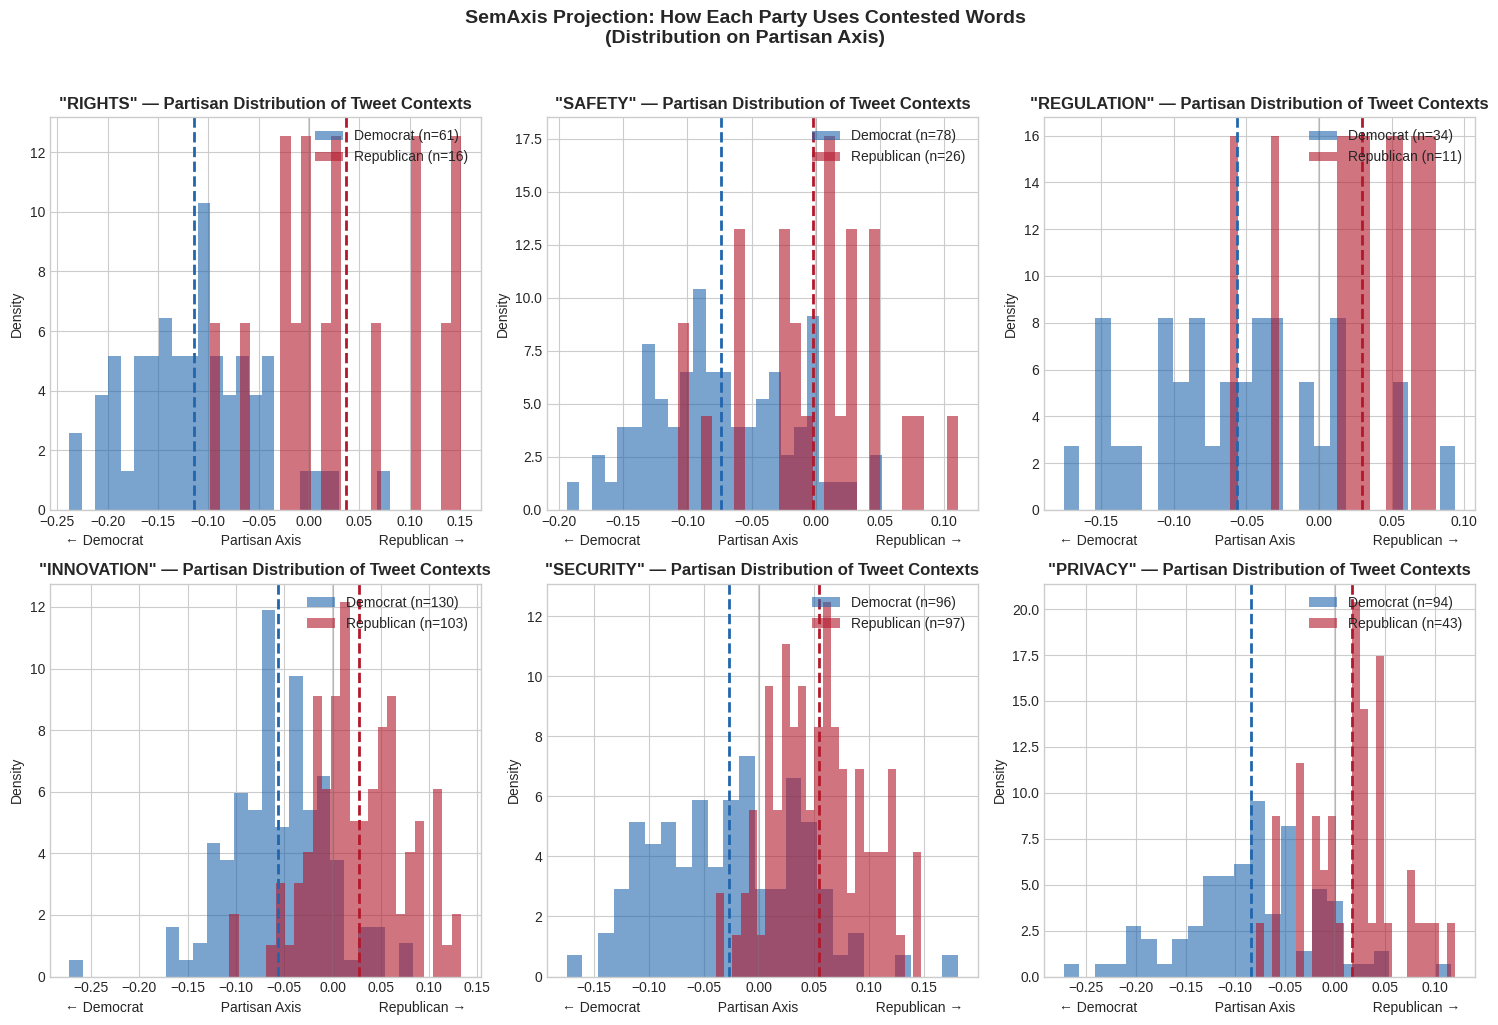

✓ Figure saved to: /content/drive/MyDrive/same_words_different_worlds/figures/10_semaxis_grid.png

SEMAXIS PROJECTION SUMMARY

Word            D Mean     R Mean     Separation
---------------------------------------------
rights          -0.1137    0.0366     0.1503    
safety          -0.0740    -0.0022    0.0718    
regulation      -0.0564    0.0299     0.0863    
innovation      -0.0562    0.0271     0.0833    
security        -0.0270    0.0541     0.0811    
privacy         -0.0842    0.0174     0.1016    


In [5]:
# Create SemAxis distributions for multiple contested words
contested_words = ['rights', 'safety', 'regulation', 'innovation', 'security', 'privacy']

fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

semaxis_results = []

for i, word in enumerate(contested_words):
    result = plot_semaxis_distribution(word, df, partisan_axis, ax=axes[i])
    if result:
        semaxis_results.append(result)

plt.suptitle('SemAxis Projection: How Each Party Uses Contested Words\n(Distribution on Partisan Axis)',
             fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()

# Save
save_path = os.path.join(PATHS['figures'], '10_semaxis_grid.png')
plt.savefig(save_path, dpi=300, bbox_inches='tight')
plt.show()

print(f"✓ Figure saved to: {save_path}")

# Print summary statistics
print("\n" + "="*60)
print("SEMAXIS PROJECTION SUMMARY")
print("="*60)
print(f"\n{'Word':<15} {'D Mean':<10} {'R Mean':<10} {'Separation':<10}")
print("-"*45)
for r in semaxis_results:
    print(f"{r['word']:<15} {r['d_mean']:<10.4f} {r['r_mean']:<10.4f} {r['mean_diff']:<10.4f}")

* "Rights": Strong separation (almost no overlap)
* "Regulation": Clear separation with distinct peaks
* "Security": Much more overlap (parties use it similarly)
* "Innovation": Moderate overlap but different means

# Cell 5: Collocation Visualizations for Multiple Words

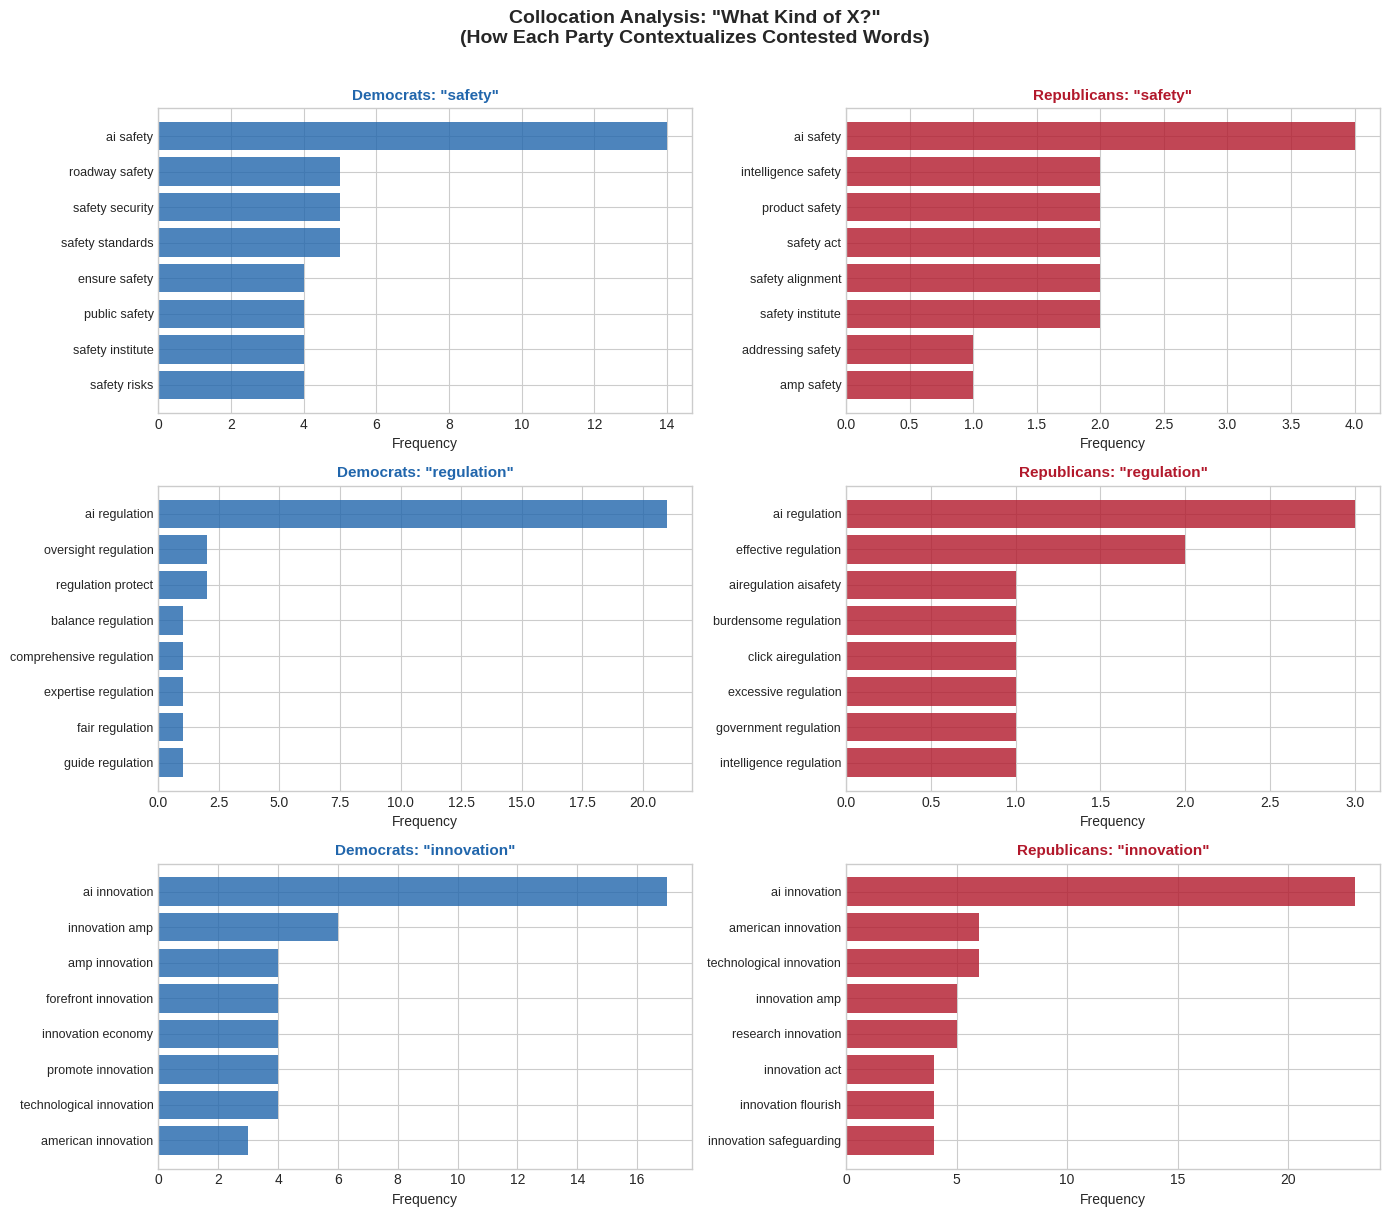

✓ Figure saved to: /content/drive/MyDrive/same_words_different_worlds/figures/11_collocation_grid.png


In [6]:
# Create collocation comparisons for multiple contested words

def get_collocations(target_word, party, df, n_gram=2, top_k=8):
    """Extract most common n-grams containing the target word for a party."""
    pattern = r'\b' + re.escape(target_word) + r'\b'
    mask = (df['party'] == party) & (df['clean_text'].str.contains(pattern, case=False, regex=True, na=False))
    texts = df[mask]['clean_text'].tolist()

    if len(texts) < 5:
        return {}

    vectorizer = CountVectorizer(ngram_range=(n_gram, n_gram), stop_words='english')

    try:
        X = vectorizer.fit_transform(texts)
        counts = X.sum(axis=0).A1
        vocab = vectorizer.get_feature_names_out()

        freq_dict = {}
        for word, count in zip(vocab, counts):
            if target_word.lower() in word.lower():
                freq_dict[word] = count

        return dict(sorted(freq_dict.items(), key=lambda x: x[1], reverse=True)[:top_k])
    except:
        return {}

def plot_collocation_comparison(word, df, ax_left, ax_right):
    """Create side-by-side collocation comparison."""
    d_collocations = get_collocations(word, 'D', df)
    r_collocations = get_collocations(word, 'R', df)

    # Democrat plot
    if d_collocations:
        phrases = list(d_collocations.keys())
        counts = list(d_collocations.values())
        ax_left.barh(range(len(phrases)), counts, color='#2166AC', alpha=0.8)
        ax_left.set_yticks(range(len(phrases)))
        ax_left.set_yticklabels(phrases, fontsize=9)
        ax_left.invert_yaxis()
        ax_left.set_xlabel('Frequency')
        ax_left.set_title(f'Democrats: "{word}"', fontsize=11, fontweight='bold', color='#2166AC')

    # Republican plot
    if r_collocations:
        phrases = list(r_collocations.keys())
        counts = list(r_collocations.values())
        ax_right.barh(range(len(phrases)), counts, color='#B2182B', alpha=0.8)
        ax_right.set_yticks(range(len(phrases)))
        ax_right.set_yticklabels(phrases, fontsize=9)
        ax_right.invert_yaxis()
        ax_right.set_xlabel('Frequency')
        ax_right.set_title(f'Republicans: "{word}"', fontsize=11, fontweight='bold', color='#B2182B')

# Create grid for 3 words
words_to_plot = ['safety', 'regulation', 'innovation']

fig, axes = plt.subplots(3, 2, figsize=(14, 12))

for i, word in enumerate(words_to_plot):
    plot_collocation_comparison(word, df, axes[i, 0], axes[i, 1])

plt.suptitle('Collocation Analysis: "What Kind of X?"\n(How Each Party Contextualizes Contested Words)',
             fontsize=14, fontweight='bold', y=1.01)
plt.tight_layout()

# Save
save_path = os.path.join(PATHS['figures'], '11_collocation_grid.png')
plt.savefig(save_path, dpi=300, bbox_inches='tight')
plt.show()

print(f"✓ Figure saved to: {save_path}")

* "Regulation": Democrats say "comprehensive", "fair", "oversight" vs. Republicans say "burdensome", "excessive", "government"

* "Safety": Democrats focus on "standards", "public safety" vs. Republicans focus on "alignment", "product safety"

# Cell 6: Extract Example Tweets

In [7]:
# Extract example tweets showing how each party uses contested words
# Focus on tweets at the extremes of the partisan axis

def get_extreme_examples(word, df, n_examples=3):
    """Get most partisan examples of word usage from each party."""

    pattern = r'\b' + re.escape(word) + r'\b'
    mask = df['clean_text'].str.contains(pattern, case=False, regex=True, na=False)
    subset = df[mask].copy()

    if len(subset) < 10:
        return None

    # Most Democratic usage (lowest partisan score)
    d_tweets = subset[subset['party'] == 'D'].nsmallest(n_examples, 'partisan_score')

    # Most Republican usage (highest partisan score)
    r_tweets = subset[subset['party'] == 'R'].nlargest(n_examples, 'partisan_score')

    return {
        'word': word,
        'd_examples': d_tweets[['clean_text', 'partisan_score', 'name']].to_dict('records'),
        'r_examples': r_tweets[['clean_text', 'partisan_score', 'name']].to_dict('records')
    }

# Get examples for key contested words
example_words = ['rights', 'safety', 'regulation', 'innovation', 'security']

print("="*60)
print("EXAMPLE TWEETS: Same Words, Different Contexts")
print("="*60)

all_examples = []

for word in example_words:
    examples = get_extreme_examples(word, df, n_examples=2)

    if examples:
        all_examples.append(examples)

        print(f"\n{'─'*60}")
        print(f"'{word.upper()}'")
        print(f"{'─'*60}")

        print(f"\n  DEMOCRAT USAGE (most D-leaning contexts):")
        for i, ex in enumerate(examples['d_examples'], 1):
            text = ex['clean_text'][:150] + "..." if len(ex['clean_text']) > 150 else ex['clean_text']
            print(f"    {i}. \"{text}\"")
            print(f"       — {ex['name']}")

        print(f"\n  REPUBLICAN USAGE (most R-leaning contexts):")
        for i, ex in enumerate(examples['r_examples'], 1):
            text = ex['clean_text'][:150] + "..." if len(ex['clean_text']) > 150 else ex['clean_text']
            print(f"    {i}. \"{text}\"")
            print(f"       — {ex['name']}")

EXAMPLE TWEETS: Same Words, Different Contexts

────────────────────────────────────────────────────────────
'RIGHTS'
────────────────────────────────────────────────────────────

  DEMOCRAT USAGE (most D-leaning contexts):
    1. "We know that there are far too many potential biases within AI technologies that could unfairly impact people of color. I am committed to advancing bi..."
       — Schumer, Charles 
    2. "As the use of AI grows, I want to make sure workers' rights are protected. That means making sure management decisions have to be made off by humans a..."
       — Casey, Robert Jr.

  REPUBLICAN USAGE (most R-leaning contexts):
    1. "Google refused to work with the U.S. military on artificial intelligence, yet had no problem opening up an AI research center in #China. The authorita..."
       — Michael Waltz R-FL
    2. "Last week, Chairman @RepGallagher called for @CommerceGov to investigate @G42ai (a multi-billion dollar AI firm based in the UAE) for its extensive ti

* "Rights": Democrats discuss worker protections and bias against people of color; Republicans discuss China and foreign threats
* "Regulation": Democrats frame it positively ("sensible guardrails"); Republicans emphasize balance with innovation
* "Innovation": Democrats link to jobs and accountability; Republicans link to military and national security

# Cell 7: Save Examples & Summary

In [8]:
# Save examples to CSV for paper reference
example_rows = []

for ex in all_examples:
    word = ex['word']
    for d_ex in ex['d_examples']:
        example_rows.append({
            'word': word,
            'party': 'D',
            'text': d_ex['clean_text'],
            'speaker': d_ex['name'],
            'partisan_score': d_ex['partisan_score']
        })
    for r_ex in ex['r_examples']:
        example_rows.append({
            'word': word,
            'party': 'R',
            'text': r_ex['clean_text'],
            'speaker': r_ex['name'],
            'partisan_score': r_ex['partisan_score']
        })

df_examples = pd.DataFrame(example_rows)
examples_path = os.path.join(PATHS['outputs'], 'example_tweets.csv')
df_examples.to_csv(examples_path, index=False)
print(f"✓ Saved: {examples_path}")

# Save SemAxis results
semaxis_df = pd.DataFrame(semaxis_results)
semaxis_path = os.path.join(PATHS['outputs'], 'semaxis_results.csv')
semaxis_df.to_csv(semaxis_path, index=False)
print(f"✓ Saved: {semaxis_path}")

print("\n" + "="*60)
print("NOTEBOOK 08 COMPLETE ✓")
print("="*60)
print("""
DEEPER SEMANTIC ANALYSIS RESULTS:

1. SEMAXIS PROJECTION
   - Visualized tweet distributions on partisan axis
   - "Rights" shows strongest separation (minimal overlap)
   - "Security" shows most overlap (bipartisan usage)
   - Clear visual evidence of different contexts per party

2. COLLOCATION ANALYSIS
   - "Regulation": D="comprehensive, fair" vs R="burdensome, excessive"
   - "Safety": D="standards, ensure" vs R="alignment, product"
   - "Innovation": D="economy, promote" vs R="american, technological"

3. EXAMPLE TWEETS
   - Concrete quotes showing partisan framing differences
   - Democrats: civil rights, worker protection, corporate accountability
   - Republicans: national security, China threat, military advantage

FIGURES SAVED:
   - 10_semaxis_rights.png
   - 10_semaxis_grid.png
   - 11_collocation_grid.png

DATA SAVED:
   - example_tweets.csv
   - semaxis_results.csv

NEXT STEPS:
   → Notebook 09: Subgroup Analysis (Chamber, speakers)
""")

✓ Saved: /content/drive/MyDrive/same_words_different_worlds/data/outputs/example_tweets.csv
✓ Saved: /content/drive/MyDrive/same_words_different_worlds/data/outputs/semaxis_results.csv

NOTEBOOK 08 COMPLETE ✓

DEEPER SEMANTIC ANALYSIS RESULTS:

1. SEMAXIS PROJECTION
   - Visualized tweet distributions on partisan axis
   - "Rights" shows strongest separation (minimal overlap)
   - "Security" shows most overlap (bipartisan usage)
   - Clear visual evidence of different contexts per party

2. COLLOCATION ANALYSIS
   - "Regulation": D="comprehensive, fair" vs R="burdensome, excessive"
   - "Safety": D="standards, ensure" vs R="alignment, product"
   - "Innovation": D="economy, promote" vs R="american, technological"

3. EXAMPLE TWEETS
   - Concrete quotes showing partisan framing differences
   - Democrats: civil rights, worker protection, corporate accountability
   - Republicans: national security, China threat, military advantage

FIGURES SAVED:
   - 10_semaxis_rights.png
   - 10_semax